# Import package

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import loggers
from pytorch_lightning.callbacks import ModelCheckpoint

In [2]:
%load_ext autoreload
%autoreload 2

# Setup environment

In [3]:
device = "cuda" if torch.cuda.is_available else "cpu"

def format_bytes(size):
    # 2**10 = 1024
    power = 2**10
    n = 0
    power_labels = {0 : '', 1: 'kilo', 2: 'mega', 3: 'giga', 4: 'tera'}
    while size > power:
        size /= power
        n += 1
    return "%.2f" % size, power_labels[n] + 'bytes'

torch.cuda.get_device_name(), format_bytes(torch.cuda.get_device_properties(device).total_memory)

('GeForce GTX 1080 Ti', ('10.92', 'gigabytes'))

# Load model

In [4]:
from preprocessing.load_dataset import PandaDataset

In [5]:
from trainer.supervised.transformers import TransformersTrainer
model = TransformersTrainer()
max_epoches = model.get_max_epoches()

>> Load from data frame


Using cache found in /home/kientiet/.cache/torch/hub/facebookresearch_semi-supervised-ImageNet1K-models_master


In [6]:
checkpoint_path = os.path.join(os.getcwd(), "checkpoint", model.model_name)
checkpoint_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    save_top_k = 5,
    verbose = True,
    monitor = 'kappa_score',
    mode = 'max'
)

checkpoint_path

'/home/kientiet/Documents/My Project/python/panda-kaggle/checkpoint/resnet50_32x4d + attention in batch'

In [7]:
tb_logger = loggers.TensorBoardLogger('logs/', name = model.model_name)
trainer = pl.Trainer(checkpoint_callback = checkpoint_callback,
                    nb_sanity_val_steps = 0, 
                    max_epochs = max_epoches, 
                    gpus = -1, 
                    logger = tb_logger)

INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [0]


# Learning finder

In [8]:
lr_finder = trainer.lr_find(model, min_lr = 1e-8, max_lr = 5., num_training = 200)

INFO:lightning:
    | Name                                                               | Type                    | Params
-----------------------------------------------------------------------------------------------------------
0   | loss_func                                                          | BCELoss                 | 0     
1   | encoder                                                            | ResNetModel             | 11 M  
2   | encoder.encoder                                                    | Sequential              | 11 M  
3   | encoder.encoder.0                                                  | Conv2d                  | 9 K   
4   | encoder.encoder.1                                                  | BatchNorm2d             | 128   
5   | encoder.encoder.2                                                  | ReLU                    | 0     
6   | encoder.encoder.3                                                  | MaxPool2d               | 0     
7   | encode

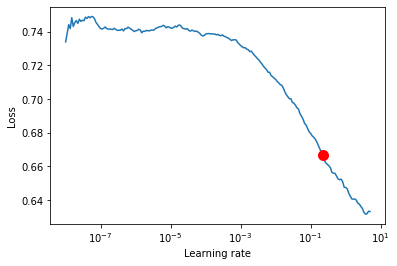

In [9]:
fig = lr_finder.plot(suggest = True)

In [10]:
model.max_lr = 2e-2
model.current_epoch = 0
model.configure_optimizers()

SGD (
Parameter Group 0
    base_momentum: 0.85
    dampening: 0
    initial_lr: 0.0008
    lr: 0.019999999517965248
    max_lr: 0.02
    max_momentum: 0.9
    min_lr: 8e-06
    momentum: 0.8500000012055691
    nesterov: False
    weight_decay: 5e-05
)

## Start to train

In [11]:
trainer.fit(model)

INFO:lightning:
    | Name                                                               | Type                    | Params
-----------------------------------------------------------------------------------------------------------
0   | loss_func                                                          | BCELoss                 | 0     
1   | encoder                                                            | ResNetModel             | 11 M  
2   | encoder.encoder                                                    | Sequential              | 11 M  
3   | encoder.encoder.0                                                  | Conv2d                  | 9 K   
4   | encoder.encoder.1                                                  | BatchNorm2d             | 128   
5   | encoder.encoder.2                                                  | ReLU                    | 0     
6   | encoder.encoder.3                                                  | MaxPool2d               | 0     
7   | encode

INFO:lightning:Detected KeyboardInterrupt, attempting graceful shutdown...


1